## Æther: Pipeline


In [1]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/cajas/Archivos/tec/semestre_8/tc3002b/tc3002b/aether/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")

In [3]:
def loadDataset(datasets: list[tuple[str, str]]):
    """Load dataset more efficiently by reading unique files only once

    Args:
        datasets (list[tuple[str, str]]): List of tuples containing the path to the labels file and the base directory of the files.
    Returns:
        pd.DataFrame: DataFrame containing the loaded data.
    """

    columns = ["id1", "id2", "plagio", "file1", "file2"]

    df = pd.DataFrame(columns=columns)

    for labels_path, base_dir in datasets:
        labels_path = Path(labels_path)
        base_dir = Path(base_dir)

        # Validate paths
        if not labels_path.exists() or not labels_path.is_file():
            raise FileNotFoundError(f"Labels file not found: {labels_path}")
        if not base_dir.exists() or not base_dir.is_dir():
            raise FileNotFoundError(f"Base directory not found: {base_dir}")

        # Load labels
        df2 = pd.read_csv(labels_path)
        
        # ensure ids are strings
        df2["id1"] = df2["id1"].astype(str)
        df2["id2"] = df2["id2"].astype(str)

        # Ensure label is an integer
        df2["plagio"] = df2["plagio"].astype(int)


        # Get unique file IDs to load only once
        unique_ids = pd.concat([df2["id1"], df2["id2"]]).unique()

        # Load files in one pass
        files = {}
        for file_id in tqdm(unique_ids, desc="Loading files"):
            path = base_dir / f"{file_id}.java"
            if path.exists():
                try:
                    files[file_id] = path.read_text(encoding="utf-8")
                except UnicodeDecodeError:
                    files[file_id] = path.read_text(encoding="latin-1")
            else:
                raise FileNotFoundError(f"File not found: {path}")

        # Map files to dataframe
        df2["file1"] = df2["id1"].map(files)
        df2["file2"] = df2["id2"].map(files)

        # Append to main dataframe
        df = pd.concat([df, df2[columns]], ignore_index=True)

    return df

In [4]:
def find_optimal_threshold(y_true, y_scores):
    """
    Find the optimal threshold for binary classification using ROC curve.
    """
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


def evaluate_model(df, threshold=None, balance_classes=True):
    if threshold is None:
        threshold = find_optimal_threshold(
            df["plagio"].values,
            df["similarity"].values,
        )
        print(f"Optimal threshold: {threshold:.2f}")

    df["predicted"] = df["similarity"].apply(lambda x: 1 if x > threshold else 0)

    report = classification_report(df["plagio"], df["predicted"])
    print(report)

    cm = confusion_matrix(df["plagio"], df["predicted"])

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Plagiarized", "Plagiarized"]
    )
    disp.plot(
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=plt.gca(),
    )
    plt.title("Confusion Matrix")
    plt.show()

    # Plot the distribution of the similarity scores
    plt.figure(figsize=(10, 7))
    plt.hist(
        df["similarity"], bins=50, alpha=0.7, color="blue", label="Similarity Scores"
    )
    plt.axvline(threshold, color="red", linestyle="--")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Similarity Scores")
    plt.show()

In [5]:
def listOfDictToDictOfTensor(list_of_dicts):
    """
    Convert a list of dictionaries to a dictionary of tensors.
    """
    keys = list_of_dicts[0].keys()
    dict_of_tensors = {key: [] for key in keys}

    for d in list_of_dicts:
        for key in keys:
            dict_of_tensors[key].append(d[key])

    for key in keys:
        # Convert the list of numpy arrays to a single numpy array, then to a tensor
        dict_of_tensors[key] = torch.tensor(np.array(dict_of_tensors[key]), device=device)

    return dict_of_tensors

In [6]:
# Define paths
LABELS_PATH = Path("../labels")
CONPLAG_LABEL_PATH = LABELS_PATH / "conplag_labels.csv"
IR_PLAG_LABEL_PATH = LABELS_PATH / "ir_plag_labels.csv"

BASE_DIR = Path("../datasets")
CONPLAG_BASE_DIR = BASE_DIR / "conplag_preprocesed"
IR_PLAG_BASE_DIR = BASE_DIR / "ir_plag_preprocessed"


# Load the dataset
print("Loading dataset...")
df2 = loadDataset(
    [(CONPLAG_LABEL_PATH, CONPLAG_BASE_DIR), (IR_PLAG_LABEL_PATH, IR_PLAG_BASE_DIR)]
)

dataset = Dataset.from_pandas(df2)

# Process dataset (tokenize files)
print("Processing dataset...")


def tokenize_function(example):
    tokenized1 = tokenizer(
        example["file1"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    tokenized2 = tokenizer(
        example["file2"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )
    return {
        "tokenized1": tokenized1,
        "tokenized2": tokenized2,
    }


tokenized_dataset = dataset.map(
    tokenize_function,
)

df = tokenized_dataset.to_pandas()

Loading dataset...


Loading files:   0%|          | 0/975 [00:00<?, ?it/s]

Loading files: 100%|██████████| 460/460 [00:00<00:00, 12604.64it/s]


Processing dataset...


Map: 100%|██████████| 1371/1371 [00:03<00:00, 350.58 examples/s]


In [7]:
# Split dataset into train, validation, and test sets
# 80% train, 10% validation, 10% test
print("Splitting dataset...")


X1 = [row["tokenized1"] for _, row in df.iterrows()]
X2 = [row["tokenized2"] for _, row in df.iterrows()]

Y = df["plagio"].values.astype(np.float32)


# Split the combined dataset
X1_train, X1_temp, Y_train, Y_temp = train_test_split(X1, Y, test_size=0.2, random_state=42)
X1_test, X1_val, Y_test, Y_val = train_test_split(X1_temp, Y_temp, test_size=0.5, random_state=42)

X2_train, X2_temp = train_test_split(X2, test_size=0.2, random_state=42)
X2_test, X2_val = train_test_split(X2_temp, test_size=0.5, random_state=42)

print("Train, validation, and test datasets prepared.")
print(f"Length of train set: {len(Y_train)}, Length of validation set: {len(Y_val)}, Length of test set: {len(Y_test)}")


Splitting dataset...
Train, validation, and test datasets prepared.
Length of train set: 1096, Length of validation set: 138, Length of test set: 137


In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Embedding model
        self.embedding_model = AutoModel.from_pretrained(
            "huggingface/CodeBERTa-small-v1"
        ).to(device)

        # Classifier
        self.fc1 = torch.nn.Linear(768, 32)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(0.6)
        self.fc2 = torch.nn.Linear(32, 16)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(0.6)
        self.fc3 = torch.nn.Linear(16, 1)
        self.sigmoid = torch.nn.Sigmoid()

        self.to(device)

    def forward(self, x1, x2):
        with torch.no_grad():
            x1 = self.embedding_model(**x1).pooler_output
            x2 = self.embedding_model(**x2).pooler_output
        
        x = torch.subtract(x1, x2)
        x = self.classifier_forward(x)
        return x

    def classifier_forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


model = Model()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.BCELoss()

history = []

In [ ]:
history_df = pd.read_csv("history.csv")
if history_df.empty:
    history_df = pd.DataFrame(columns=[ "loss", "accuracy", "val_loss", "val_accuracy"])

for row in history_df.iterrows():
    history.append(
        {
            "loss": row[1]["loss"],
            "acc": row[1]["acc"],
            "val_loss": row[1]["val_loss"],
            "val_acc": row[1]["val_acc"],
        }
    )

# Load model
model_path = Path("model4_epoch_500.pth")
if model_path.exists():
    print(f"Loading model from {model_path}")
    model.load_state_dict(torch.load(model_path))


In [ ]:
starting_epoch = 0
num_epochs = 500
batch_size = 32

In [ ]:
# Training loop
train_Y = torch.from_numpy(Y_train).unsqueeze(1).cpu().numpy()
val_Y = torch.from_numpy(Y_val).unsqueeze(1).cpu().numpy()

for epoch in range(starting_epoch, num_epochs):
    model.train()
    curr = {}
    acc_loss = []
    outputs_acc = []
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for i in tqdm(range(0, len(Y_train), batch_size), desc="Training Batch"):
        batch_X1 = listOfDictToDictOfTensor(X1_train[i : i + batch_size])
        batch_X2 = listOfDictToDictOfTensor(X2_train[i : i + batch_size])
        batch_Y = torch.from_numpy(Y_train[i : i + batch_size]).to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(batch_X1, batch_X2)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        acc_loss.append(loss.item())
        outputs_acc.append(outputs)

    curr["loss"] = np.mean(acc_loss)
    outputs_acc = np.concat([out.detach().cpu().numpy() for out in outputs_acc], axis=0)
    train_predictions = (outputs_acc > 0.5).astype(int)
    train_accuracy = (train_predictions == train_Y).mean()
    curr["acc"] = train_accuracy.item()

    if (epoch + 1) % 50 == 0:
        # Save the model
        torch.save(model.state_dict(), f"model4_epoch_{epoch + 1}.pth")
        history_df = pd.DataFrame(history)
        history_df.to_csv("history.csv", index=False)
        print(f"Model saved at epoch {epoch + 1}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_outputs_acc = []
        for i in tqdm(range(0, len(Y_val), batch_size), desc="Validating Batch"):
            batch_X1 = listOfDictToDictOfTensor(X1_val[i : i + batch_size])
            batch_X2 = listOfDictToDictOfTensor(X2_val[i : i + batch_size])
            batch_Y = torch.from_numpy(Y_val[i : i + batch_size]).to(device).unsqueeze(1)
            val_outputs = model(batch_X1, batch_X2)
            val_outputs_acc.append(val_outputs.cpu().numpy())
        val_outputs_acc = np.concatenate(val_outputs_acc, axis=0)
        val_loss = criterion(
            torch.from_numpy(val_outputs_acc).to(device),
            torch.from_numpy(Y_val).to(device).unsqueeze(1),
        )
        val_predictions = (val_outputs_acc > 0.5).astype(int)
        val_accuracy = (val_predictions == val_Y).mean()

    curr["val_loss"] = val_loss.item()
    curr["val_acc"] = val_accuracy.item()

    history.append(curr)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {curr['loss']:.4f}, Acc: {curr['acc']:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy.item():.4f}"
    )



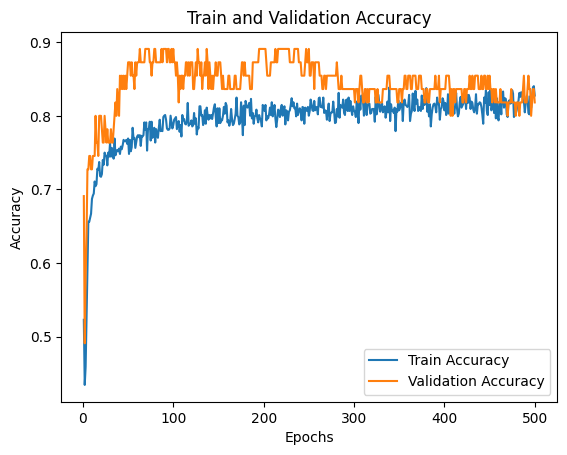

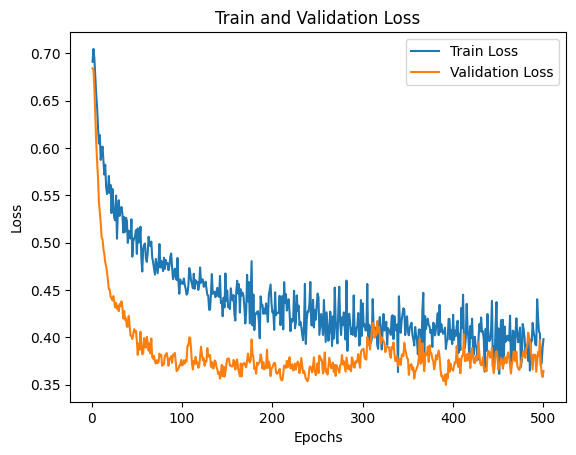

In [28]:
acc = [ x["acc"] for x in history ]
val_acc = [ x["val_acc"] for x in history ]
loss = [ x["loss"] for x in history ]
val_loss = [ x["val_loss"] for x in history ]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# test the model
model.eval()
with torch.no_grad():
    outputs_acc = []
    for i in tqdm(range(0, len(Y_test), batch_size), desc="Testing Batch"):
        batch_X1 = listOfDictToDictOfTensor(X1_test[i : i + batch_size])
        batch_X2 = listOfDictToDictOfTensor(X2_test[i : i + batch_size])
        batch_Y = torch.from_numpy(Y_test[i : i + batch_size]).to(device).unsqueeze(1)

        outputs = model(batch_X1, batch_X2)
        outputs_acc.append(outputs.cpu().numpy())
    outputs_acc = np.concatenate(outputs_acc, axis=0)
    
    test_Y = torch.from_numpy(Y_test).unsqueeze(1).cpu().numpy()

df_test = pd.DataFrame(
    {
        "similarity": outputs_acc.flatten(),
        "plagio": test_Y.flatten(),
    }
)

Testing Batch: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


              precision    recall  f1-score   support

         0.0       0.81      0.90      0.86        73
         1.0       0.88      0.77      0.82        64

    accuracy                           0.84       137
   macro avg       0.84      0.83      0.84       137
weighted avg       0.84      0.84      0.84       137



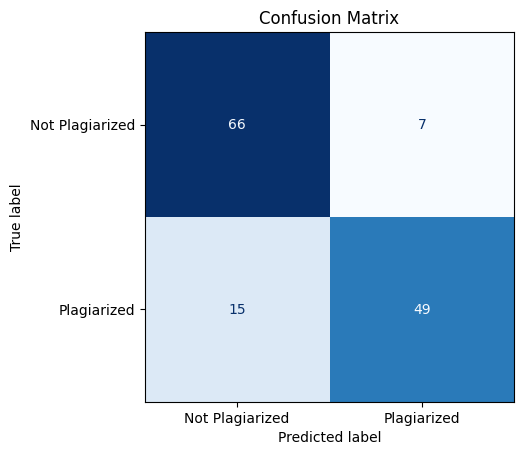

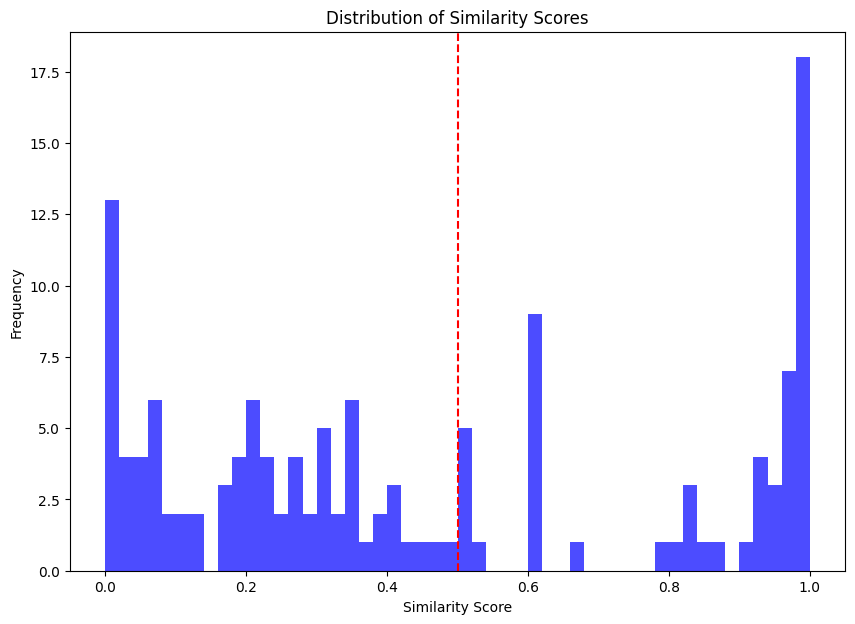

In [12]:
evaluate_model(df_test, threshold=0.5)

In [33]:
# test the model
model.eval()
with torch.no_grad():
    outputs_acc = []
    for i in tqdm(range(0, len(Y_train), batch_size), desc="Testing Batch"):
        batch_X1 = listOfDictToDictOfTensor(X1_train[i : i + batch_size])
        batch_X2 = listOfDictToDictOfTensor(X2_train[i : i + batch_size])
        batch_Y = torch.from_numpy(Y_train[i : i + batch_size]).to(device).unsqueeze(1)

        outputs = model(batch_X1, batch_X2)
        outputs_acc.append(outputs.cpu().numpy())
    outputs_acc = np.concatenate(outputs_acc, axis=0)
    
    train_Y = torch.from_numpy(Y_train).unsqueeze(1).cpu().numpy()

df_train = pd.DataFrame(
    {
        "similarity": outputs_acc.flatten(),
        "plagio": train_Y.flatten(),
    }
)

Testing Batch: 100%|██████████| 35/35 [00:24<00:00,  1.43it/s]


              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       621
         1.0       0.95      0.93      0.94       475

    accuracy                           0.95      1096
   macro avg       0.95      0.95      0.95      1096
weighted avg       0.95      0.95      0.95      1096



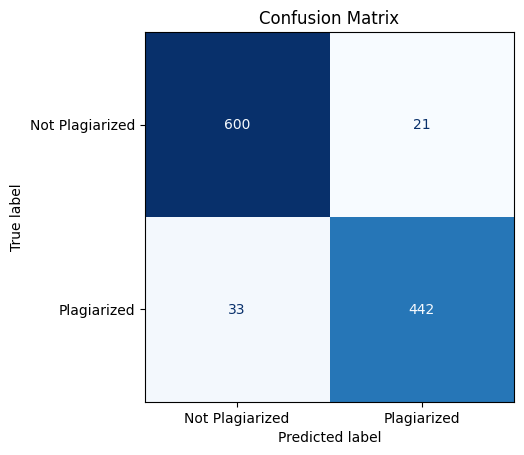

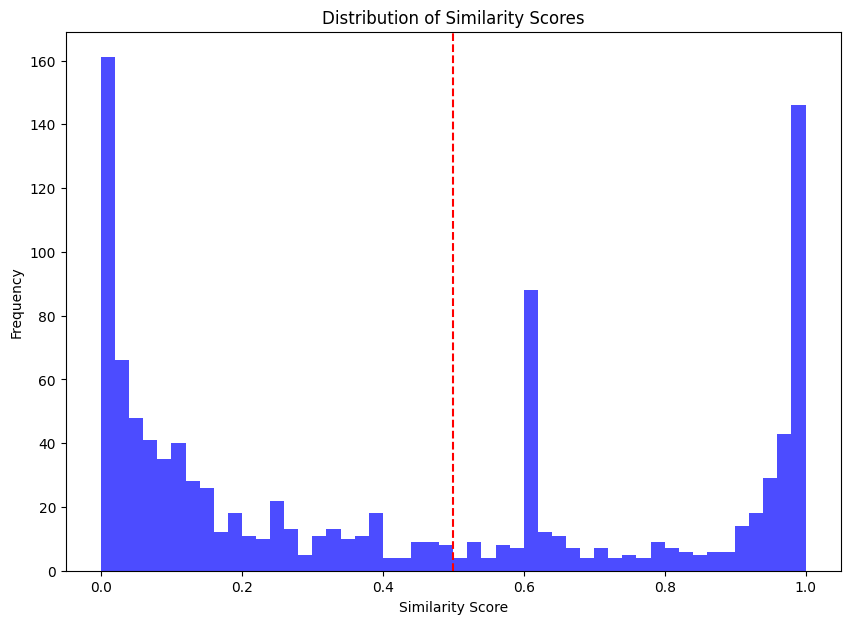

In [34]:
evaluate_model(df_train, 0.5)